# Lung Segmentation from Chest X-Ray using U-Net

## Import libraries

In [1]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from glob import glob
from tqdm import tqdm

## Data Preparation

In [2]:
!mkdir ../input_c
!mkdir ../input_c/segmentation
!mkdir ../input_c/segmentation/test
!mkdir ../input_c/segmentation/train
!mkdir ../input_c/segmentation/train/augmentation
!mkdir ../input_c/segmentation/train/image
!mkdir ../input_c/segmentation/train/mask
!mkdir ../input_c/segmentation/onlylung

In [3]:
INPUT_C_DIR = os.path.join("..", "input_c")
INPUT_DIR = os.path.join("..", "input")

SEGMENTATION_DIR = os.path.join(INPUT_C_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_onlylung_DIR = os.path.join(SEGMENTATION_DIR, "onlylung")
SEGMENTATION_SOURCE_DIR = os.path.join(INPUT_DIR, "pulmonary-chest-xray-abnormalities")

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "ChinaSet_AllFiles", "ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(INPUT_DIR, "shcxr-lung-mask", "mask", "mask")

#### Function for Visualization

In [4]:
def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
                                        
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret



#### Split and write image data to the directory

In [5]:
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png'))
shenzhen_test = shenzhen_mask_dir[0:50]
shenzhen_train= shenzhen_mask_dir[50:]

for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
    image = cv2.resize(image, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    
    if (mask_file in shenzhen_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
    else:
        filename, fileext = os.path.splitext(base_file)

        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)

100%|██████████| 566/566 [02:02<00:00,  4.63it/s]


#### Visualize Image, Mask, Merged image

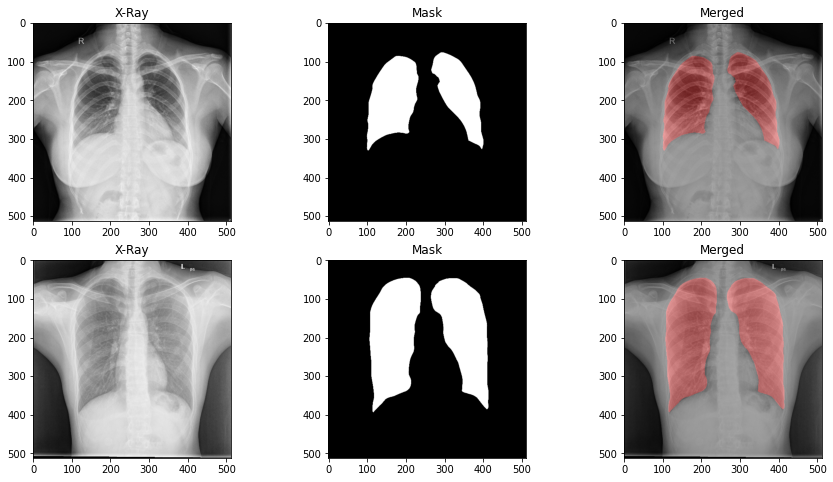

In [6]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
merged_image = add_colored_mask(image, mask_image)
                          
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Merged")
axs[0, 2].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
merged_image = add_colored_mask(image, mask_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Merged")
axs[1, 2].imshow(merged_image)

In [7]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files))

(516, 100, 516)

In [8]:
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

#### Function Metric Evaluation

In [9]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = keras.sum(keras.abs(y_true * y_pred))
    sum_ = keras.sum(keras.square(y_true)) + keras.sum(keras.square(y_pred))
    jac = (intersection) / (sum_ - intersection)
    return jac

#### Function for testing model

In [10]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))
        only_lung_file = os.path.join(save_path, "%s_onlylung%s" % (filename, fileext))

        cv2.imwrite(result_file, img)
        
        pred_image = cv2.imread(result_file)
        image = cv2.imread(os.path.join(save_path,"{}{}".format(filename,fileext)))
        cv2.imwrite(only_lung_file, cv2.bitwise_and(pred_image, image))

In [11]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_predict" not in test_file)]



In [12]:
validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "mask"), target_size=(512, 512)))

len(test_files), len(validation_data)

(50, 2)

#### Apply augmentation to training data

In [13]:
BATCH_SIZE=2

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'mask', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))


## Modeling

A U-Net consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. 

### Encoder of U-Net

Encoder blocks contain two Conv2D layers activated by ReLU, followed by a MaxPooling and Dropout layer.

In [14]:
# Encoder Utilties

def conv2d_block(input_tensor, n_filters, kernel_size=3):
    """
    Adds convolutional layers with the parameters passed to it.

    Args:
    input_tensor (tensor) -- the input tenor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size of the convolution
    """
    # first layer 
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding="same")(x)
        x = tf.keras.layers.Activation("relu")(x)

    return x

def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
    """
    Adds two convolutional blocks and then perform sampling on output of convolution.

    Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size of convolution

    Returns:
    f - the output features of the convolution block
    p - the maxpooled features with dropout
    """

    f = conv2d_block(inputs, n_filters=n_filters)
    p = tf.keras.layers.MaxPool2D(pool_size=(2,2))(f)
    p = tf.keras.layers.Dropout(0.3)(p)

    return f, p

def encoder(inputs):
    """
    This function defines the encoder or downsampling path.

    Args:
    inputs (tensor) -- batch of input images

    Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
    """
    f1, p1 = encoder_block(inputs, n_filters=32, pool_size=(2, 2), dropout=0.3)
    f2, p2 = encoder_block(p1, n_filters=64, pool_size=(2, 2), dropout=0.3)
    f3, p3 = encoder_block(p2, n_filters=128, pool_size=(2, 2), dropout=0.3)
    f4, p4 = encoder_block(p3, n_filters=256, pool_size=(2, 2), dropout=0.3)

    return p4, (f1, f2, f3, f4)

### Bottleneck

A bottleneck follows the encoder block and is used to extract more features. This does not have a pooling layer so the dimensionality remains the same.

In [15]:
def bottleneck(inputs):
    """
    This function defines the bottleneck convolutions to extract more features before the unsampling layers.
    """

    bottle_neck = conv2d_block(inputs, n_filters=512)

    return bottle_neck

### Decoder of U-Net

Decoder which upsamples the features back to the original image size. At each upsampling level, you will take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

In [16]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=2, strides=2, dropout=0.3):
    """
    Defines the one decoder block of the UNet

    Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

    Returns:
    c (tensor) -- output features of the decoder block
    """
    u = tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=kernel_size,
                                      strides=strides, padding="same")(inputs)
    c = tf.keras.layers.concatenate([u, conv_output],axis=3)                                      
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters=n_filters, kernel_size=3)

    return c

def decoder(inputs, convs, output_channels):
    """
    Defines the decoder of the UNet chaining together 4 decoder blocks. 

    Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

    Returns:
    outputs (tensor) -- the pixel wise label map of the image
    """

    f1, f2, f3, f4 = convs
    # 5 is the bottleneck if you ask 
    c6 = decoder_block(inputs, conv_output=f4, n_filters=256, kernel_size=(2,2),
                     strides=(2,2), dropout=0.3)

    c7 = decoder_block(c6, conv_output=f3, n_filters=128, kernel_size=(2,2),
                     strides=(2,2), dropout=0.3)

    c8 = decoder_block(c7, conv_output=f2, n_filters=64, kernel_size=(2,2),
                     strides=(2,2), dropout=0.3)

    c9 = decoder_block(c8, conv_output=f1, n_filters=32, kernel_size=(2,2),
                     strides=(2,2), dropout=0.3)

    outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation="sigmoid")(c9)

    return outputs

### Putting it all together

build the UNet by chaining the encoder, bottleneck, and decoder. specify the number of output channels 1. That is because there are two possible labels for each pixel: lung and not lung.

In [17]:
OUTPUT_CHANNELS = 1

def unet():
    """
 abs   Defines the UNet by connecting the encoder, bottleneck and decoder.
    """
    
    # specify the input shape
    inputs = tf.keras.layers.Input(shape=(512, 512, 1,))

    # feed the inputs to the encoder
    encoder_output, convs = encoder(inputs)

    # feed the encoder output to the bottleneck
    bottle_neck = bottleneck(encoder_output)

    # feed the bottleneck and encoder block outputs to the decoder
    # specify the number of classes ia the `output_channels` argument
    outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

    # create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# instantiate the model
tf.keras.backend.clear_session()
model = unet()

2022-08-09 08:11:55.683342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 08:11:55.795764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 08:11:55.796536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 08:11:55.798196: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=dice_coef_loss,
              metrics=[dice_coef, iou, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        activation[0][0]                 
______________________________________________________________________________________________

#### Train the model

In [19]:
EPOCHS=50
model_checkpoint = ModelCheckpoint('unet_lung_seg.hdf5', 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE, 
                              epochs=EPOCHS, 
                              callbacks=[model_checkpoint],
                              validation_data = validation_data)

Found 516 images belonging to 1 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 516 images belonging to 1 classes.


2022-08-09 08:11:59.378435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-09 08:12:02.183108: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


258/258 [==============================] - 70s 234ms/step - loss: -0.3639 - dice_coef: 0.3639 - iou: 0.3071 - binary_accuracy: 0.3179 - val_loss: -0.5127 - val_dice_coef: 0.5127 - val_iou: 0.3752 - val_binary_accuracy: 0.3431

Epoch 00001: val_loss improved from inf to -0.51268, saving model to unet_lung_seg.hdf5
Epoch 2/50
258/258 [==============================] - 59s 228ms/step - loss: -0.5099 - dice_coef: 0.5099 - iou: 0.3920 - binary_accuracy: 0.4933 - val_loss: -0.6621 - val_dice_coef: 0.6621 - val_iou: 0.4982 - val_binary_accuracy: 0.6752

Epoch 00002: val_loss improved from -0.51268 to -0.66213, saving model to unet_lung_seg.hdf5
Epoch 3/50
258/258 [==============================] - 59s 231ms/step - loss: -0.7370 - dice_coef: 0.7370 - iou: 0.5936 - binary_accuracy: 0.8729 - val_loss: -0.7202 - val_dice_coef: 0.7202 - val_iou: 0.5658 - val_binary_accuracy: 0.7655

Epoch 00003: val_loss improved from -0.66213 to -0.72020, saving model to unet_lung_seg.hdf5
Epoch 4/50
258/258 [===

## Evaluation

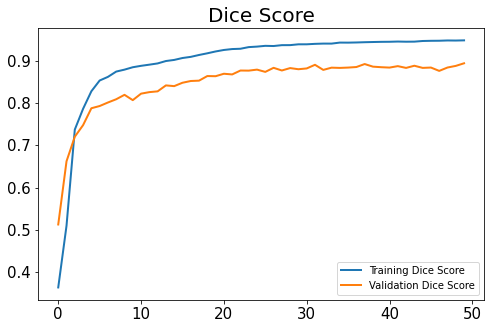

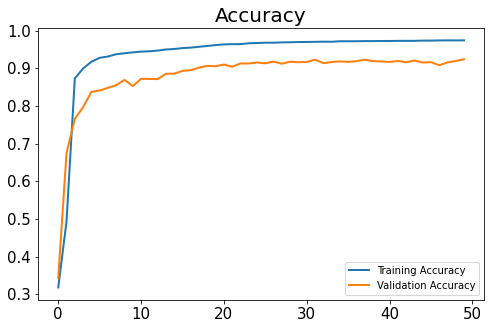

In [20]:
training_dice = history.history['dice_coef']
validation_dice = history.history['val_dice_coef']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

plt.figure(figsize=(8,5))
plt.plot(training_dice, linewidth=2)
plt.plot(validation_dice, linewidth=2)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title("Dice Score", fontsize=20)
plt.legend(['Training Dice Score', 'Validation Dice Score'])

# axs[0].set_title("Dice Score", fontsize=20)
# axs[0].plot(training_dice)
# axs[0].plot(validation_dice)
# axs[0].legend(['Training Dice Score', 'Validation Dice Score'])

plt.figure(figsize=(8,5))
plt.plot(training_accuracy, linewidth=2)
plt.plot(validation_accuracy, linewidth=2)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title("Accuracy", fontsize=20)
plt.legend(['Training Accuracy', 'Validation Accuracy'])


# axs[1].set_title("Accuracy", fontsize=20)
# axs[1].set_xticks(fontsize=20)
# axs[1].plot(training_accuracy)
# axs[1].plot(validation_accuracy)
# axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

## Predicting test data

In [21]:
test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


50/50 [==============================] - 1s 12ms/step


#### Visualize the results

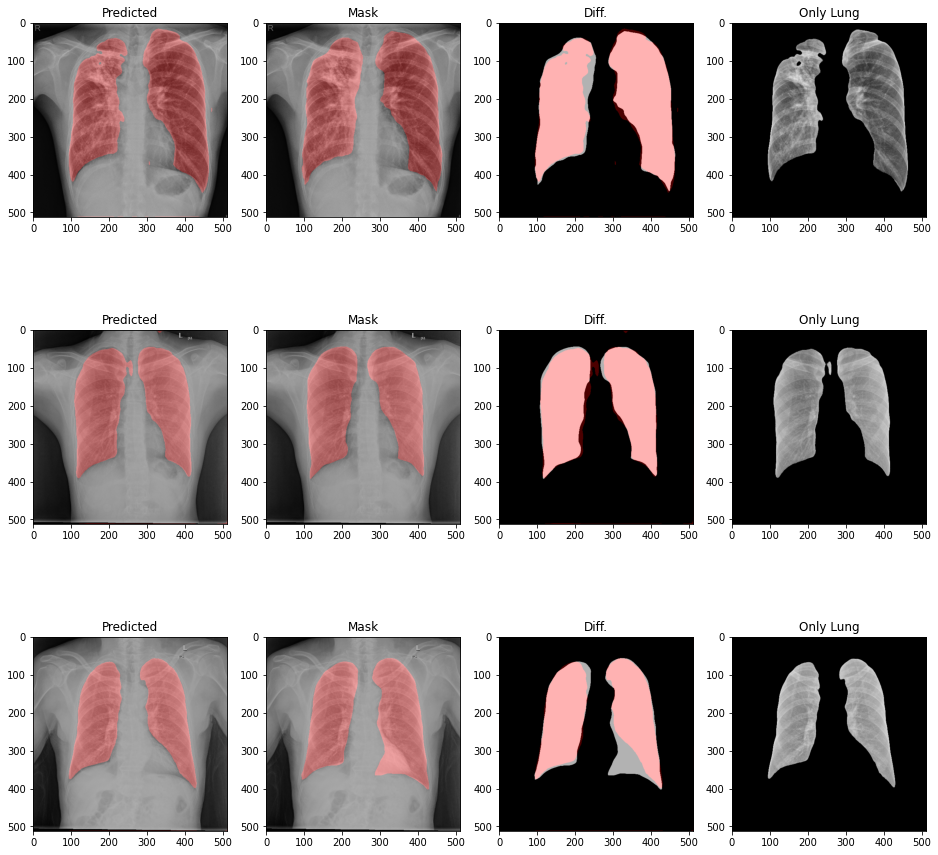

In [22]:
image = cv2.imread("../input_c/segmentation/test/CHNCXR_0408_1.png")
predict_image = cv2.imread("../input_c/segmentation/test/CHNCXR_0408_1_predict.png")
mask_image = cv2.imread("../input_c/segmentation/test/CHNCXR_0408_1_mask.png")
onlylung = cv2.imread("../input_c/segmentation/test/CHNCXR_0408_1_onlylung.png")

fig, axs = plt.subplots(3, 4, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Mask")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))
axs[0, 3].set_title("Only Lung")
axs[0, 3].imshow(onlylung)

image = cv2.imread("../input_c/segmentation/test/CHNCXR_0300_0.png")
predict_image = cv2.imread("../input_c/segmentation/test/CHNCXR_0300_0_predict.png")
mask_image = cv2.imread("../input_c/segmentation/test/CHNCXR_0300_0_mask.png")
onlylung = cv2.imread("../input_c/segmentation/test/CHNCXR_0300_0_onlylung.png")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Mask")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))
axs[1, 3].set_title("Only Lung")
axs[1, 3].imshow(onlylung)

image = cv2.imread("../input_c/segmentation/test/CHNCXR_0253_0.png")
predict_image = cv2.imread("../input_c/segmentation/test/CHNCXR_0253_0_predict.png")
mask_image = cv2.imread("../input_c/segmentation/test/CHNCXR_0253_0_mask.png")
onlylung = cv2.imread("../input_c/segmentation/test/CHNCXR_0253_0_onlylung.png")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Mask")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))
axs[2, 3].set_title("Only Lung")
axs[2, 3].imshow(onlylung)